In [83]:
import pandas as pd
import numpy as np
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt

from deep_shadow import *
from utils import *

### Store tile heights in CSV files

In [92]:
dates = ['summer', 'winter', 'spring']
cities = ['la', 'bos', 'nyc', 'chi', 'sp', 'bue', 'dc',
          'joh', 'syd', 'tok', 'par', 'mex', 'sea', 'aus']

for city in cities:
    t_ij = set()
    for date in dates:
        df = pd.read_csv('data/evaluation/%s-%s-16.csv'%(city, date))
        t_ij = t_ij.union(set(zip(df['i'], df['j'])))
    
    avg_tile_heights = []
    for tile in t_ij:
        i,j = tile
        img = cv2.imread('data/heights_new/%s/%d/%d/%d.png'%(city, zoom, i, j), cv2.IMREAD_GRAYSCALE)
        values = (img / 255.0) * 550
        masked = np.ma.masked_where(values == 0, values)
        
        mean = 0 if np.ma.count(masked) == 0 else np.ma.mean(masked)
        avg_tile_heights.append([i, j, mean])

    # create a dataframe from the list
    df = pd.DataFrame(avg_tile_heights, columns=['i', 'j', 'height'])

    # sort the dataframe by i and j
    df = df.sort_values(by=['i', 'j'])
    
    # store the dataframe as csv file
    df.to_csv('data/tile_heights/%s-%s.csv'%(city, zoom), index=False)


### Calculate the average height tile quantiles of all **train cities** combined

In [50]:
# append all these csv files into one and find the percentiles of the heights
train_cities = ['aus', 'par', 'syd', 'sp', 'mex', 'la', 'chi']

# files = glob.glob('data/tile_heights/*.csv')
df = pd.concat([pd.read_csv('data/tile_heights/%s-16.csv'%(city)) for city in train_cities], ignore_index=True)

df.quantile([0.1, 0.25, 0.5, 0.75, 0.95])['height']

0.10     5.807628
0.25     6.470588
0.50     6.470588
0.75     7.627339
0.95    13.582397
Name: height, dtype: float64

### Bin tile heights into groups

In [52]:
files = glob.glob('data/evaluation/*-summer-16.csv')
results = {}

for filepath in files:
    city = filepath.split('\\')[1].split('-')[0]
    zoom = 16

    df = pd.read_csv('data/tile_heights/%s-%d.csv' % (city, zoom))

    bins = [0, 8, 14, np.inf]
    labels = ['[0-8)', '[8-14)', '>=14']
    df['height_bin'] = pd.cut(df['height'], bins=bins, labels=labels, include_lowest=True)

    counts = df['height_bin'].value_counts()
    counts = counts.sort_index()

    results[city] = counts

df_counts = pd.DataFrame.from_dict(results, orient='index')
df_counts.columns = ['[0-8)', '[8-14)', '>=14']

# create a DataFrame with percentages as a column for each city
df_percentages = df_counts.apply(lambda x: (x / x.sum()) * 100, axis=1)
df_percentages.columns = ['[0-8)', '[8-14)', '>=14']

# concatenate the two dataframes
df = pd.concat([df_counts], keys=['Counts', 'Percentages'])

df.to_csv('./data/tile_height_distribution.csv', index=True, index_label=['Metric', 'City'])

### Save tile height distribution plot

In [3]:
train_cities = ['aus', 'par', 'syd', 'sp', 'mex', 'la', 'chi']
test_cities = ['dc', 'nyc', 'joh', 'bue', 'bos', 'sea', 'tok']

(0.0, 4000.0)

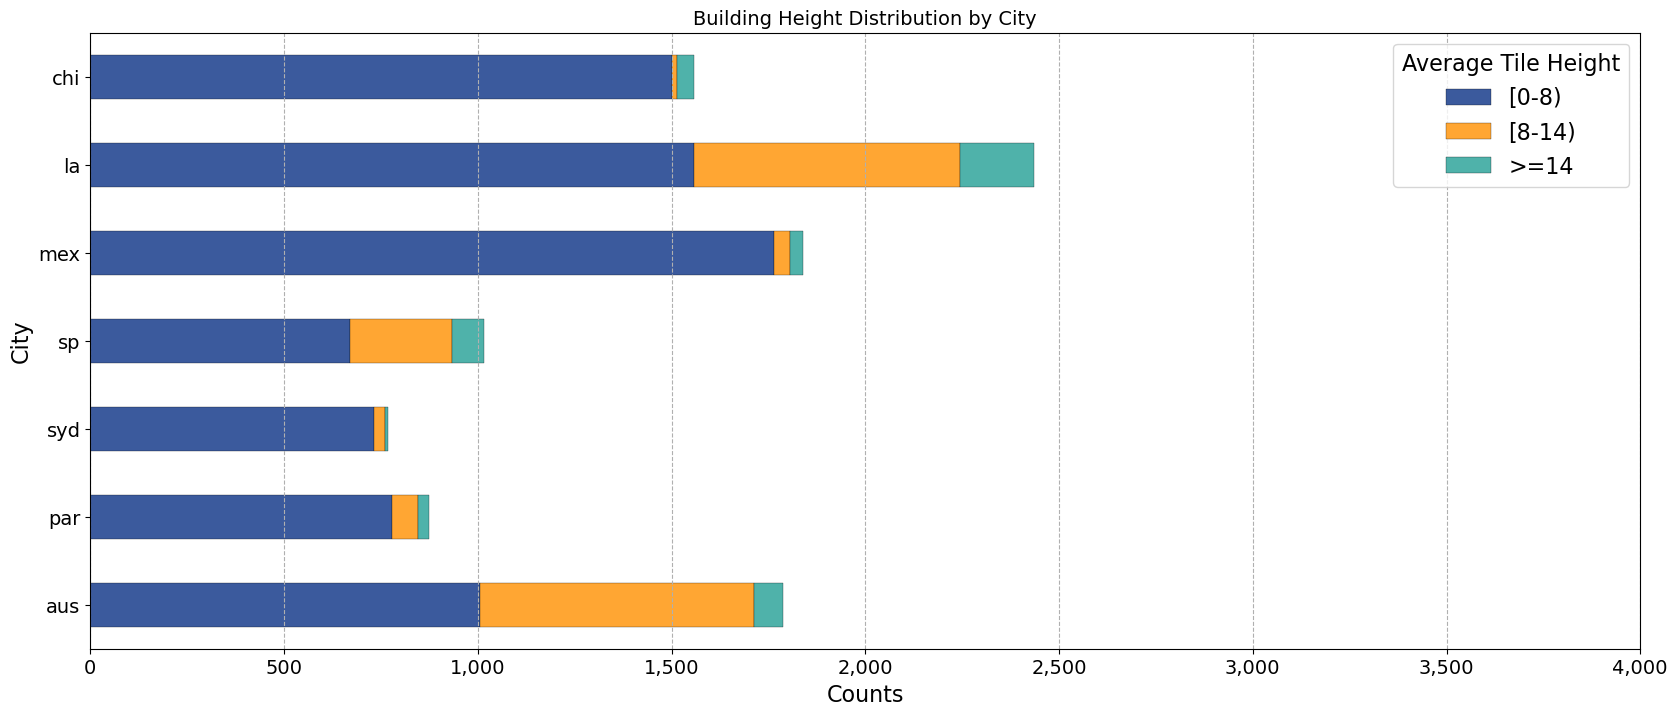

In [76]:
# plot percentage distributions for each city

df = pd.read_csv('./data/tile_height_distribution.csv', index_col=[0, 1])
df = df.loc['Counts']

df = df.loc[train_cities]

colors = ['#3b5a9d', '#ffa633', '#4fb2aa', '#e7298a']

# df = df.loc[test_cities]
ax = df.plot(kind='barh', stacked=True, color=colors, figsize=(20, 8), linewidth=0.2, edgecolor='black')

plt.title('Building Height Distribution by City', fontsize=14)

plt.xlabel('Counts', fontsize=16)
plt.ylabel('City', fontsize=16)


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

legend = plt.legend(title='Average Tile Height', fontsize=16)
plt.setp(legend.get_title(), fontsize=16)

ax.xaxis.grid(True, linestyle='--')
ax.set_xlim([0, 4000])

# frame1 = plt.gca()
# frame1.axes.xaxis.set_ticklabels([])
# frame1.axes.yaxis.set_ticklabels([])
# # remove xlabel and ylabel
# ax.set(xlabel=None)
# ax.set(ylabel=None)
# ax.get_legend().remove()

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# plt.title('', fontsize=14);

# plt.savefig('./data/tile_height_distribution.png', dpi=300, bbox_inches='tight')
# plt.close()

### Load DeepShadow model ckpt

In [4]:
tf.keras.backend.clear_session()
down_stack, up_stack = get_generator_arch('resnet9', attn=False)
deep_shadow = DeepShadow(512, 512, down_stack, up_stack, latitude=True, date=True, loss_funcs=[ssim_loss, sobel_loss, l1_loss], type='resnet9', attention=False)
deep_shadow.restore('training_checkpoints_new/uniform_cities_resnet_wo_attn__ssim_sobel_plus_l1')

### Sample tiles according to tile height bins and compute results using the model

In [71]:
height_path = 'data/heights_new'
shadow_path = 'data/shadows'
prediction_path = 'data/shadows_new'

files = glob.glob('data/heights_new/*')
cities = [filepath.split('\\')[1] for filepath in files]
dates = ['summer', 'winter', 'spring']
zoom = 16

def sobel(img): return tf.image.sobel_edges(img)

for city in cities:    
    df = pd.read_csv('data/tile_heights/%s-%d.csv' % (city, zoom))
    results = []

    for date in dates:
        bins = [0, 8, 14, np.inf]
        labels = ['[0-8)', '[8-14)', '>=14']
        df['height_bin'] = pd.cut(df['height'], bins=bins, labels=labels, include_lowest=True)
        
        for label in labels:
            df_label = df[df['height_bin'] == label]
            
            maes, mses, rmses, sobels, ssims = [], [], [], [], []
            for i, j in zip(df_label['i'], df_label['j']):

                try:
                    ip_height = cv2.imread('%s/%s/%d/%d/%d.png'%(height_path, city, zoom, i, j), cv2.IMREAD_GRAYSCALE)
                    ip_height = ip_height / 255.0

                    gt = cv2.imread('%s/%s-%s/%d/%d/%d.png'%(shadow_path, city, date, zoom, i, j), cv2.IMREAD_GRAYSCALE)
                    gt = gt / 255.0

                    gt = np.where(ip_height > 0, 0, gt)

                    prediction = cv2.imread('%s/%s-%s/%d/%d/%d.png'%(prediction_path, city, date, zoom, i, j), cv2.IMREAD_GRAYSCALE)
                    prediction = prediction / 255.0

                    # We did not do this before. This is to remove shadows from buildings in the prediction
                    prediction = np.where(ip_height > 0, 0, prediction)

                    maes.append(np.mean(np.abs(gt-prediction)))
                    mses.append(np.mean((prediction - gt) ** 2))
                    rmses.append(np.sqrt(np.mean((prediction - gt) ** 2)))

                    # convert 256x256 to rank 3 tensor
                    gt = np.expand_dims(gt, axis=0)
                    gt = np.expand_dims(gt, axis=-1)

                    prediction = np.expand_dims(prediction, axis=0)
                    prediction = np.expand_dims(prediction, axis=-1)
                    
                    ssim = tf.reduce_mean(tf.image.ssim(tf.convert_to_tensor(gt),
                                  tf.convert_to_tensor(prediction), 1.0))
                    ssims.append(ssim.numpy())

                    sobel_loss = tf.reduce_mean(tf.square(
                        sobel(tf.convert_to_tensor(gt)) - sobel(tf.convert_to_tensor(prediction))))
                    sobels.append(sobel_loss.numpy())
                
                except Exception as e:
                    print(e)
                    

            results.append([date, 16, len(maes), label, sum(maes)/len(maes), sum(mses)/len(mses), sum(rmses)/len(rmses), sum(sobels)/len(sobels), sum(ssims)/len(ssims)])

    res = pd.DataFrame(results, columns=['season', 'zoom', 'numer of tiles', 'height bin', 'mae', 'mse', 'rmse', 'sobel', 'ssim'])
    res.to_csv('data/evaluation_height/%s-%d.csv' % (city, zoom), index=False)

In [73]:
# Average per test city per height bin for all seasons and store in one csv file

df_csv = pd.DataFrame(columns=['city', 'height bin', 'mae', 'mse', 'rmse', 'sobel', 'ssim'])
for city in test_cities:
    df = pd.read_csv('data/evaluation_height/%s-%d.csv' % (city, zoom))[['height bin', 'numer of tiles', 'mae', 'mse', 'rmse', 'sobel', 'ssim']]
    df = df.groupby(['height bin']).mean()
    df = df.reindex(['[0-8)', '[8-14)', '>=14'])
    # rmse, mae, mse, sobel, then ssim
    df = df.reindex(['numer of tiles', 'rmse', 'mae', 'mse', 'sobel', 'ssim'], axis=1)
    # round to 4 decimal places
    df = df.round(4)
    df = df.reset_index()
    # add city column in the beginning
    df.insert(0, 'city', city)
    # number of tiles is an integer
    df['numer of tiles'] = df['numer of tiles'].astype(int)
    
    df_csv = pd.read_csv('data/evaluation_height/_res.csv')
    df_csv = pd.concat([df_csv, df], ignore_index=True)
    df_csv.to_csv('data/evaluation_height/_res.csv', index=False)

In [ ]:
# total number of tiles in three height bins for all 14 cities

bin_1, bin_2, bin_3 = 0, 0, 0
for city in test_cities + train_cities:
    df = pd.read_csv('data/evaluation_height/%s-%d.csv' % (city, zoom))[['height bin', 'numer of tiles']]
    df = df.groupby(['height bin']).mean()
    bin_1 += df.loc['[0-8)', 'numer of tiles']
    bin_2 += df.loc['[8-14)', 'numer of tiles']
    bin_3 += df.loc['>=14', 'numer of tiles']